# Find TIPS
## After training the network, load the weights and apply network to classify each voxel of a test cases

In [7]:
from __future__ import division
%matplotlib inline
%pylab inline

import pyprind
import glob
import os
import numpy as np
import nrrd
import numpy as np
from sklearn import datasets, svm, metrics, decomposition
from sklearn.externals import joblib
import time
from joblib import Parallel, delayed  
import multiprocessing
num_cores = multiprocessing.cpu_count()
USERPATH = os.path.expanduser("~")
print(USERPATH)
from mpl_toolkits.mplot3d import Axes3D
import six.moves.cPickle as pickle

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.utils import np_utils, generic_utils
from keras.utils.np_utils import to_categorical
from keras.datasets import cifar10
from keras.models import model_from_json

from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint

from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


Populating the interactive namespace from numpy and matplotlib
/Users/guillaume


Using TensorFlow backend.


In [12]:
def shuffle_in_unison_inplace(a, b):
    assert len(a) == len(b)
    p = numpy.random.permutation(len(a))
    return a[p], b[p]

def simple_test(y):
    x=[]
    for yi in y:
        if yi:
            x.append(np.ones(64000))
        else: x.append(np.zeros(64000))
    return np.array(x)

## Load pre-processed data to check network performance

In [47]:
p=20 # dimension of the patch
x=6 # weight number
if p ==10:
    f_Xdata = open('X_data_n3.save', 'rb')
    f_ydata = open('y_data_n3.save', 'rb')
else:
    f_Xdata = open('X_data_n2.save', 'rb')
    f_ydata = open('y_data_n2.save', 'rb')

# we load the data via pickle
X_data = pickle.load(f_Xdata)
y_data= pickle.load(f_ydata)

# we shuffle the data
X_data,y_data = shuffle_in_unison_inplace(X_data,y_data)

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_data)
y_data = encoder.transform(y_data)

# we make sure the data is in the right format
X_data = X_data.astype('float32')

X_data  -= np.mean(X_data)
X_data /= np.std(X_data)
k = int(len(y_data)*0.)
X_train = X_data[:k]
y_train = y_data[:k]
X_test = X_data[k+1:]
y_test = y_data[k+1:]


In [50]:
# we load the model with the trained weights
model = model_from_json(open('my_model_architecture%d.json'%x).read())
model.load_weights('my_model_weights_2d_%d.h5'%x)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [52]:
# we check what was the performance of this CNN on the trained data
score = model.evaluate(X_test[0:][:], y_test[:][:], batch_size=64)
print('Score',score)

1427/1427 [==============================] - 1s     
Score [0.12686937508064294, 0.95444989517675716]


In [53]:
# model.save_weights('weights.save')

In [63]:
# we load a test case
nrrdData = nrrd.read('/Users/guillaume/Dropbox/2016-projectweekdata/Output Volume.nrrd')
im = nrrdData[0]
im = im[100:160,80:130,70:130]
s = im.shape
print(s)

(60, 50, 60)


In [64]:
def findtips(N, p=20):
    '''
    Find the tip in the image by computing testing patches at every voxel position
    TODO: make this method more efficient
    '''
    p = p
    xmiddle = s[0]//2
    ymiddle = s[1]//2
    zmiddle = s[2]//2
    
    x0= xmiddle - xmiddle//N
    y0= ymiddle - ymiddle//N
    z0= zmiddle - zmiddle//N
    
    xe= xmiddle + xmiddle//N
    ye= ymiddle + ymiddle//N
    ze= zmiddle + zmiddle//N
    
    tips = []
    bar = pyprind.ProgBar(xmiddle//N*2, title='Find_tip', stream=sys.stdout)
    for xi in range(x0, xe-p):
        for yi in range(y0, ye-p):
            vols = [im[xi:xi+p,yi:yi+p,zi:zi+p] for zi in range(z0,ze-p)]
            # we normalize the data (centered on mean 0 and rescaled in function of the STD)
            volnorm = [ x-np.mean(x) for x in vols]
            volnorm2 = [x/np.std(x) for x in volnorm]
            cube = np.array(volnorm2)
            res = model.predict_proba(cube, batch_size=32, verbose=False)
            indices = np.where(res[:,0]==1)
            # we add the coordinates of the center voxel of the patches that tested positive
            for z in indices[0]:
                tips.append([xi+p/2,yi+p/2,z0+p/2+z])
        bar.update()
    return tips

In [65]:
# find the tips for patches with size p
res=findtips(1,p)

Find_tip
0%                          100%
[####################          ] | ETA: 00:00:25

In [66]:
res

[[11.0, 16.0, 48.0],
 [11.0, 16.0, 49.0],
 [11.0, 17.0, 48.0],
 [11.0, 17.0, 49.0],
 [12.0, 16.0, 49.0],
 [12.0, 17.0, 48.0],
 [12.0, 17.0, 49.0],
 [12.0, 18.0, 32.0],
 [12.0, 18.0, 33.0],
 [12.0, 18.0, 34.0],
 [12.0, 18.0, 35.0],
 [12.0, 18.0, 36.0],
 [12.0, 18.0, 47.0],
 [12.0, 18.0, 48.0],
 [12.0, 18.0, 49.0],
 [12.0, 19.0, 32.0],
 [12.0, 19.0, 33.0],
 [12.0, 19.0, 34.0],
 [12.0, 19.0, 35.0],
 [12.0, 19.0, 36.0],
 [12.0, 19.0, 37.0],
 [12.0, 19.0, 38.0],
 [12.0, 19.0, 39.0],
 [12.0, 19.0, 48.0],
 [12.0, 19.0, 49.0],
 [12.0, 20.0, 35.0],
 [12.0, 20.0, 36.0],
 [13.0, 17.0, 48.0],
 [13.0, 17.0, 49.0],
 [13.0, 18.0, 29.0],
 [13.0, 18.0, 30.0],
 [13.0, 18.0, 31.0],
 [13.0, 18.0, 32.0],
 [13.0, 18.0, 33.0],
 [13.0, 18.0, 34.0],
 [13.0, 18.0, 35.0],
 [13.0, 18.0, 36.0],
 [13.0, 18.0, 37.0],
 [13.0, 18.0, 38.0],
 [13.0, 18.0, 39.0],
 [13.0, 18.0, 46.0],
 [13.0, 18.0, 47.0],
 [13.0, 18.0, 48.0],
 [13.0, 18.0, 49.0],
 [13.0, 19.0, 28.0],
 [13.0, 19.0, 29.0],
 [13.0, 19.0, 30.0],
 [13.0, 19.0,

## Creation of a labelmap from the voxel that tested positive

In [67]:
mask = np.zeros(im.shape)
for coord in res:
    mask[int(coord[0]),int(coord[1]),int(coord[2])]=1.0
nrrd.write('mask%d.nrrd'%x, mask)
nrrd.write('im%d.nrrd'%x, im)

/Users/guillaume/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


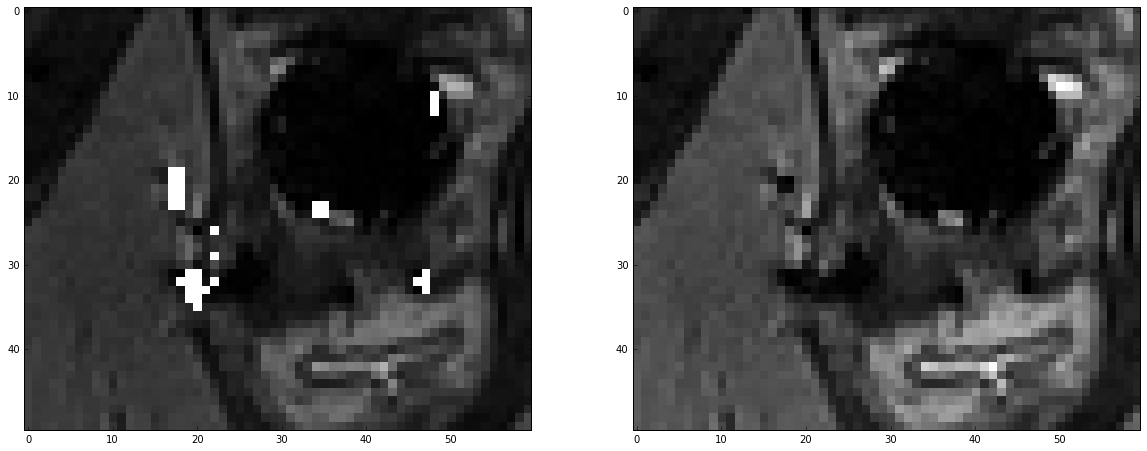

In [69]:
# We display one axial slice
Z = 13
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.imshow((np.clip(mask[:,:,Z]*255+im[:,:,Z]/2,a_min=0,a_max=200)).transpose(),  cmap='gray', interpolation='nearest')
ax2 = fig.add_subplot(122)
ax2.imshow(im[:,:,Z].transpose(), cmap='gray', interpolation='nearest')